## Codificación guiada por la variable objetivo o target

En las lecciones anteriores de esta sección, vimos como convertir una etiqueta en un número usando codificación one-hot, reemplazando por un dígito o reemplazando por la frecuencia o número de observaciones. Estos métodos son sencillos, y no (o casi nunca) hacen supuestos sobre los datos y funcionan generalmente bien en una variedad de escenarios.

Hay métodos que por el contrario si permiten capturar  información y a la vez pre-procesar las etiquetas de una variable categórica. Estos métodos incluyen:

- Ordenar las etiquetas de acuerdo al target
- Reemplazar las etiquetas por el promedio del target (codificación por la media / por el target) 
- Reemplazar las etiquetas por el radio de probabilidad del target - ya sea 1 o 0
- Pesos de evidencia (Weight of evidence)

Todos estos métodos tienen algo en común:
- la codificación es **guiada por el target**, y
- crean una **relación monotónica** entre la variable y el target


### Monotonicidad

Una relación monotónica es una relación que tiene lo siguiente:

- (1) cuando el valor de una variable incrementa, asi mismo sucede con la otra variable; o
- (2) cuando el valor de una variable incrementa, el valor de la otra variable decrece.

En este caso, si el valor de la variable independiente (predictor) incrementa, lo mismo sucede con el target (variable objetivo), o por el contrario, si la variable incrementa, el valor del target decrece.


### Ventajas 

- Captura la información dentro de la categoría, por lo tanto incrementa el poder predictivo de las variables.
- Crea una relación monotónica entre la variable y el target, por lo tanto es adecuada para modelos lineales.
- No expande el espacio de las variables


### Limitaciones

- Tiende a causar sobreajustes
- Es difícil de validar usando las librerías existentes

### Nota

Los métodos discutidos en esta y las próximas 3 lecciones pueden ser usados con variables numéricas, luego de discretizarlas. Esto crea una relación monotónica entre la variable numérica y el target y por lo tanto mejora el desempeño de los modelos lineales. Discutiremos esto en más detalle en la sección "Discretización"


===============================================================================


## Codificación por la media del target o variable objetivo

La codificación por la media del target o variable objetivo implica reemplazar cada categoría por el promedio o media del valor del target para dicha categoría. Por ejemplo, si tenemos la variable ciudad, con las categorías de Londres, Manchester y Bristol, y tenemos la tasa promedio de incumplimiento de pago de préstamos para cada ciudad. Si Londres tiene una tasa de 30%,  reemplazamos Londres con 0.3, si la tasa es 20% para Manchester, reemplazamos esta categoría con 0.20 y asi sucesivamente.

Vamos a realizar codificación por la media usando:
- pandas
- Feature-Engine

y veremos las ventajas y limitaciones de cada una de estas implementaciones usando los datos del Titanic.




In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# separar los datos
from sklearn.model_selection import train_test_split

# codificación con feature-engine
from feature_engine.categorical_encoders import MeanCategoricalEncoder

In [2]:
# cargar datos

data = pd.read_csv(
    '../titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [3]:
# llenar valores ausentes na en la variable embarked

data['embarked'].fillna('Missing', inplace=True)

In [4]:
# Ahora reemplazamos los valores de la variable cabin 
# con la primera letra de cada etiqueta en cabin
# simplificando de esta forma los valores en la variable 
# y facilitar el demo 

data['cabin'] = data['cabin'].astype(str).str[0]

In [5]:
# miremos cuantas categorías tiene cada variable

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' etiquetas')

survived :  2  etiquetas
sex :  2  etiquetas
cabin :  9  etiquetas
embarked :  4  etiquetas


In [6]:
# exploremos las categorías en cada variable

data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'T', 'F', 'G'], dtype=object)

In [7]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [8]:
data['embarked'].unique()

array(['S', 'C', 'Missing', 'Q'], dtype=object)

### Importante sobre codificación

Calculamos la media del target por cada categoría usando el set de entrenamiento; y luego usamos este mapeo para codificar las variables en el set de prueba

**Para usar esta técnica con pandas, necesitmaos mantener el target en el set de entrenamiento**

In [9]:
# separemos en set de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']], # esta vez mantenemos el target en la variable
    data['survived'],  # target
    test_size=0.3,  # porcentaje de observaciones en el set de prueba
    random_state=0)  # semilla asegurar reproducibilidad

X_train.shape, X_test.shape

((916, 4), (393, 4))

### Exploremos la relación original entre las variables categóricas y el target

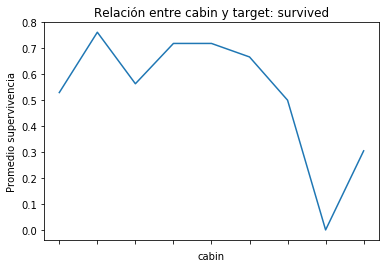

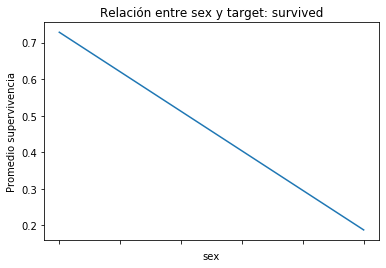

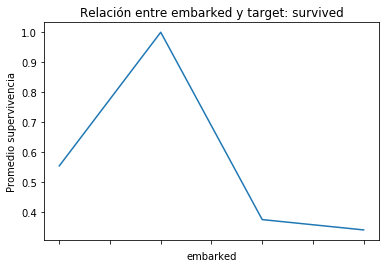

In [10]:
# Exploremos la relación original entre las variables categóricas 
# y el target (survived)

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relación entre {} y target: survived'.format(var))
    fig.set_ylabel('Promedio supervivencia')
    plt.show()

Podemos ver en la relación entre el target y las variables cabin y embarked, que esta sube y baja dependiendo de la categoría. 


## Codificación por la media con pandas

### Ventajas

- rápido
- devuelve un dataframe de pandas

### Limitaciones:

- no preserva la información del set de entrenamiento para propagarlo al set de prueba

Necesitamos capturar y guardar los mapeos uno por uno, manualmente, si estamos planeando usarlos en producción


In [11]:
# calculemos el promedio del target para cada categoría
X_train.groupby(['cabin'])['survived'].mean()

cabin
A    0.529412
B    0.761905
C    0.563380
D    0.718750
E    0.718750
F    0.666667
G    0.500000
T    0.000000
n    0.304843
Name: survived, dtype: float64

In [12]:
# hagamos lo mismo pero capturemos la información en un diccionario

ordered_labels = X_train.groupby(['cabin'])['survived'].mean().to_dict()

ordered_labels

{'A': 0.5294117647058824,
 'B': 0.7619047619047619,
 'C': 0.5633802816901409,
 'D': 0.71875,
 'E': 0.71875,
 'F': 0.6666666666666666,
 'G': 0.5,
 'T': 0.0,
 'n': 0.30484330484330485}

In [13]:
# ahora, reemplacemos las etiquetas con el promedio del target
X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

In [14]:
# exploremos el resultado

X_train['cabin'].head(10)

501     0.304843
588     0.304843
402     0.304843
1193    0.304843
686     0.304843
971     0.304843
117     0.718750
540     0.304843
294     0.563380
261     0.718750
Name: cabin, dtype: float64

In [15]:
# agrupemos los comandos anteriores en dos funciones

def find_category_mappings(df, variable, target):
    return df.groupby([variable])[target].mean().to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    X_train[variable] = X_train[variable].map(ordinal_mapping)
    X_test[variable] = X_test[variable].map(ordinal_mapping)

In [16]:
# ahora repitamos el proceso (con un ciclo) para cada una de 
# las variables categóricas

for variable in ['sex', 'embarked']:
    mappings = find_category_mappings(X_train, variable, 'survived')
    integer_encode(X_train, X_test, variable, mappings)

In [17]:
# veamos el resultado 
X_train.head()

,cabin,sex,embarked,survived
501,0.304843,0.728358,0.338957,1
588,0.304843,0.728358,0.338957,1
402,0.304843,0.728358,0.553073,1
1193,0.304843,0.187608,0.373494,0
686,0.304843,0.728358,0.373494,1


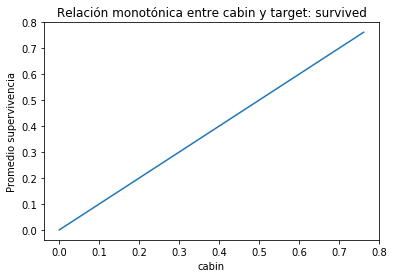

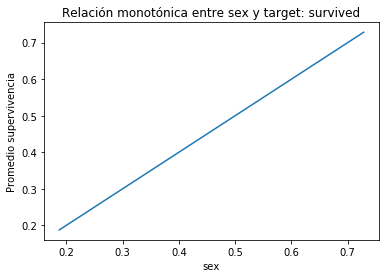

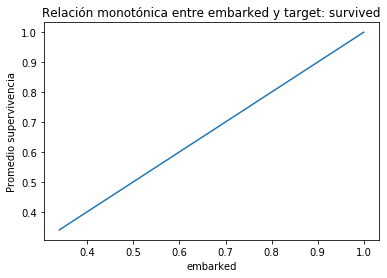

In [18]:
# inspeccionemos la relación monotónica
# entre las variable transformadas y el target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relación monotónica entre {} y target: survived'.format(var))
    fig.set_ylabel('Promedio supervivencia')
    plt.show()

Podemos ver en las gráficas que la relación entre las categorías y el target ahora es monotónica.

### Nota

Reemplazar las etiquetas con el código anterior, va a generar valores faltantes para las categorías presentes en el set de prueba pero que no lo están en el set de entrenamiento. 

Por lo tanto es extremadamente importante, manejar las etiquetas poco comunes con prelación. Explicaremos como hacer esto más adelante en otro notebook.



## ## Codificación por la media con Feature-Engine

Si usamos Feature-Engine, en lugar de pandas, no necesitamos mantener el target en el set de entrenamiento.

In [19]:
# separemos en set de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']], # esta vez mantenemos el target en la variable
    data['survived'],  # target
    test_size=0.3,  # porcentaje de observaciones en el seg te prueba
    random_state=0)  # semilla para asegurar reproducibilidad

X_train.shape, X_test.shape


((916, 3), (393, 3))

In [20]:
mean_enc = MeanCategoricalEncoder(
    variables=['cabin', 'sex', 'embarked'])

In [21]:
# cuando ajustamos el transformador, necesitamos pasar el target
# tambien, como cualquier otro de los predictores en Scikit-learn 

mean_enc.fit(X_train, y_train)

MeanCategoricalEncoder(variables=['cabin', 'sex', 'embarked'])

In [22]:
# en el dict del encoder podemos ver el promedio del target
# asignado a cada una de las categorías por cada variable
mean_enc.encoder_dict_

{'cabin': {'A': 0.5294117647058824,
  'B': 0.7619047619047619,
  'C': 0.5633802816901409,
  'D': 0.71875,
  'E': 0.71875,
  'F': 0.6666666666666666,
  'G': 0.5,
  'T': 0.0,
  'n': 0.30484330484330485},
 'sex': {'female': 0.7283582089552239, 'male': 0.18760757314974183},
 'embarked': {'C': 0.553072625698324,
  'Missing': 1.0,
  'Q': 0.37349397590361444,
  'S': 0.3389570552147239}}

In [23]:
# esta es la lista de variables que el codificador transforma
mean_enc.variables

['cabin', 'sex', 'embarked']

In [24]:
X_train = mean_enc.transform(X_train)
X_test = mean_enc.transform(X_test)

# exploremos los resultados
X_train.head()

,cabin,sex,embarked
501,0.304843,0.728358,0.338957
588,0.304843,0.728358,0.338957
402,0.304843,0.728358,0.553073
1193,0.304843,0.187608,0.373494
686,0.304843,0.728358,0.373494



**Nota**

Si el argmento 'variables' se fija en 'None' (ninguno), entonces el codificador automáticamente indentificará  **todas las variables categóricas**. Maravilloso verdad?

El codificador no codificará las variables numéricas. Por lo tanto, si algunas de tus variables categóricas son de hecho numéricas, necesitas hacer el 're-cast' o cambio a tipo 'object' antes de usar el codificador.

Si hay una variable en el set de prueba, para el cual el codificador no tiene un número para asignar ( la categoría no estaba presente en el set de entrenamiento), el codificador devolverá un error para alertarte del problema


